In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.constants import C_0
from tidy3d.plugins.mode import ModeSolver

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')
plt.style.use("plot_style.mplstyle")

In [2]:
def single_wg_mode_data_calculator(wg_width, wg_height, sidewall_angle, n_medium, n_background, target_neff, freqs, freq0, Lx = 20, Ly=20, Lz=20, dl=0.05, min_steps_per_wvl = 20):
  Lx, Ly, Lz = Lx, Ly, Lz

  wg_medium = td.Medium.from_nk(n=n_medium, k=0, freq=freq0)
  background_medium = td.Medium.from_nk(n=n_background, k=0, freq=freq0)

  wvl_um = C_0/freq0

  vertices = np.array([(-1.0, -wg_width/2.0), (1.0, -wg_width/2.0),
                      (1.0, wg_width/2.0), (-1.0, wg_width/2.0)])
  wg = td.Structure(
      geometry=td.PolySlab(
          vertices=vertices,
          axis=2,
          slab_bounds=(-wg_height/2.0, wg_height/2.0),
          sidewall_angle=sidewall_angle,
          reference_plane="bottom"
      ),
      medium=wg_medium
  )

  # automatic grid specification
  grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)
  run_time = 1e-12

  sim = td.Simulation(
      size=(Lx, Ly, Lz),
      grid_spec=grid_spec,
      structures=[wg],
      run_time=run_time,
      medium=background_medium,
      boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
      
  )

  plane = td.Box(
      center=(0, 0, 0),
      size=(0, Ly, Lz)
  )

  mode_spec = td.ModeSpec(
      num_modes=1,
      target_neff=target_neff,
      group_index_step=True
  )

  mode_solver = ModeSolver(
      simulation=sim,
      plane=plane,
      mode_spec=mode_spec,
      freqs=freqs,
  )

  mode_data = mode_solver.solve()

  n_eff = mode_data.n_eff.sel(mode_index=0, f=freq0).values

  return (mode_solver, mode_data, n_eff)

In [3]:
Lx, Ly, Lz = 30, 30, 30
dl = 0.01

min_steps_per_wvl = 30

wg_width = 0.8
wg_height = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

single_mode_wg_sidewall_angle = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium = 1.968
n_background = 1.45

In [4]:
wg_width_range = np.linspace(0.1, 0.3, 11)

mode_solver_data = []
mode_data = []
mode_neff = []

for wg_width in tqdm(wg_width_range):
  single_mode_solver, single_mode_data, single_mode_n_eff = single_wg_mode_data_calculator(
    wg_width, wg_height, single_mode_wg_sidewall_angle, n_medium, n_background, n_medium, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )
  mode_solver_data.append(single_mode_solver)
  mode_data.append(single_mode_data)
  mode_neff.append(single_mode_n_eff)

  0%|          | 0/11 [00:00<?, ?it/s]

[01:41:18] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

  9%|▉         | 1/11 [07:48<1:18:05, 468.55s/it]

[01:58:01] WARNING: Mode '0' appears to undergo a discontinuous change between  
           frequencies '231601450603053.4' and '230449204580152.66' (overlap:   
           '0.33').                                                             

100%|██████████| 11/11 [1:04:11<00:00, 350.12s/it]


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


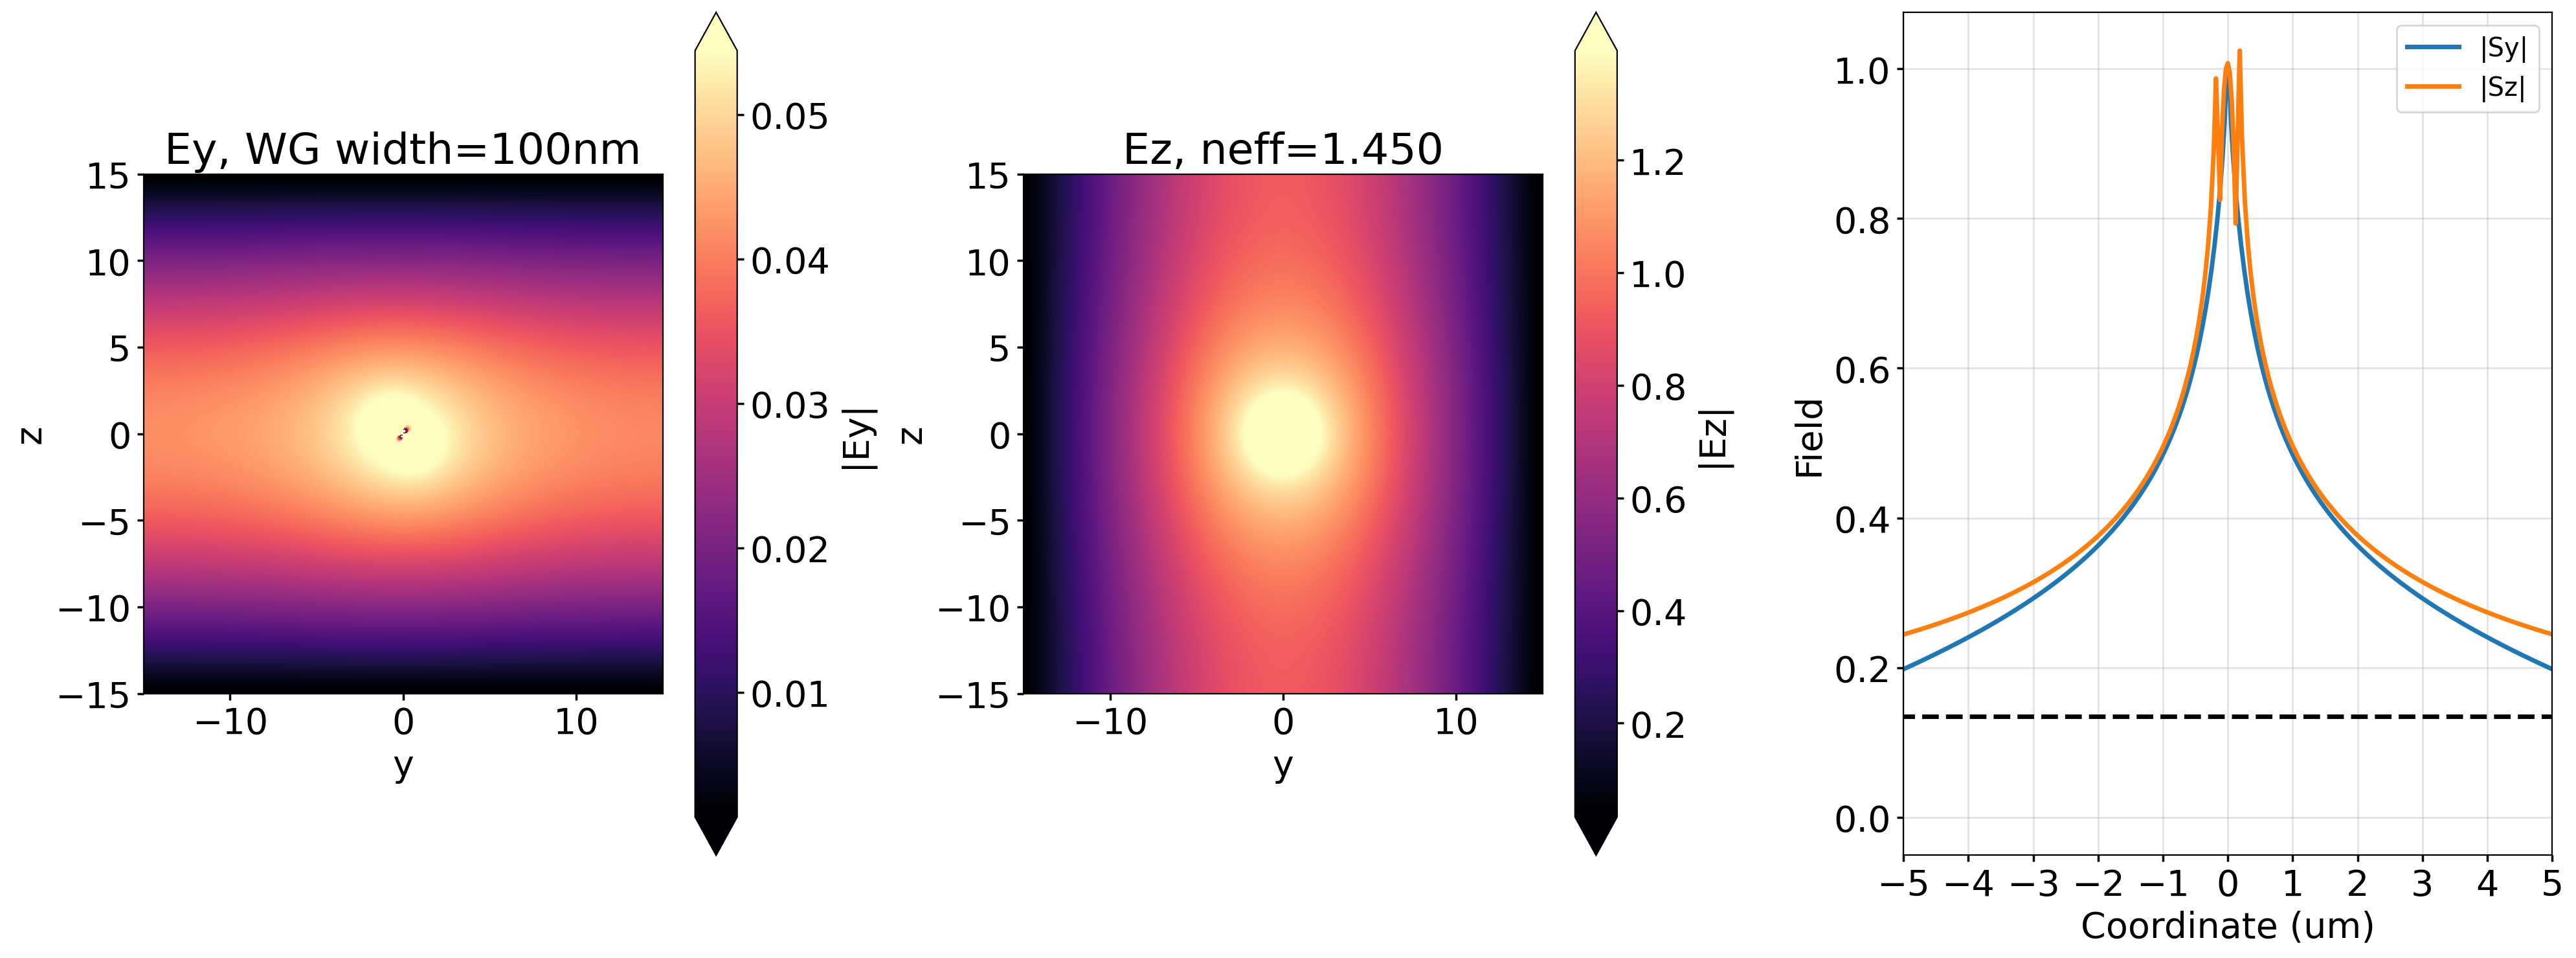

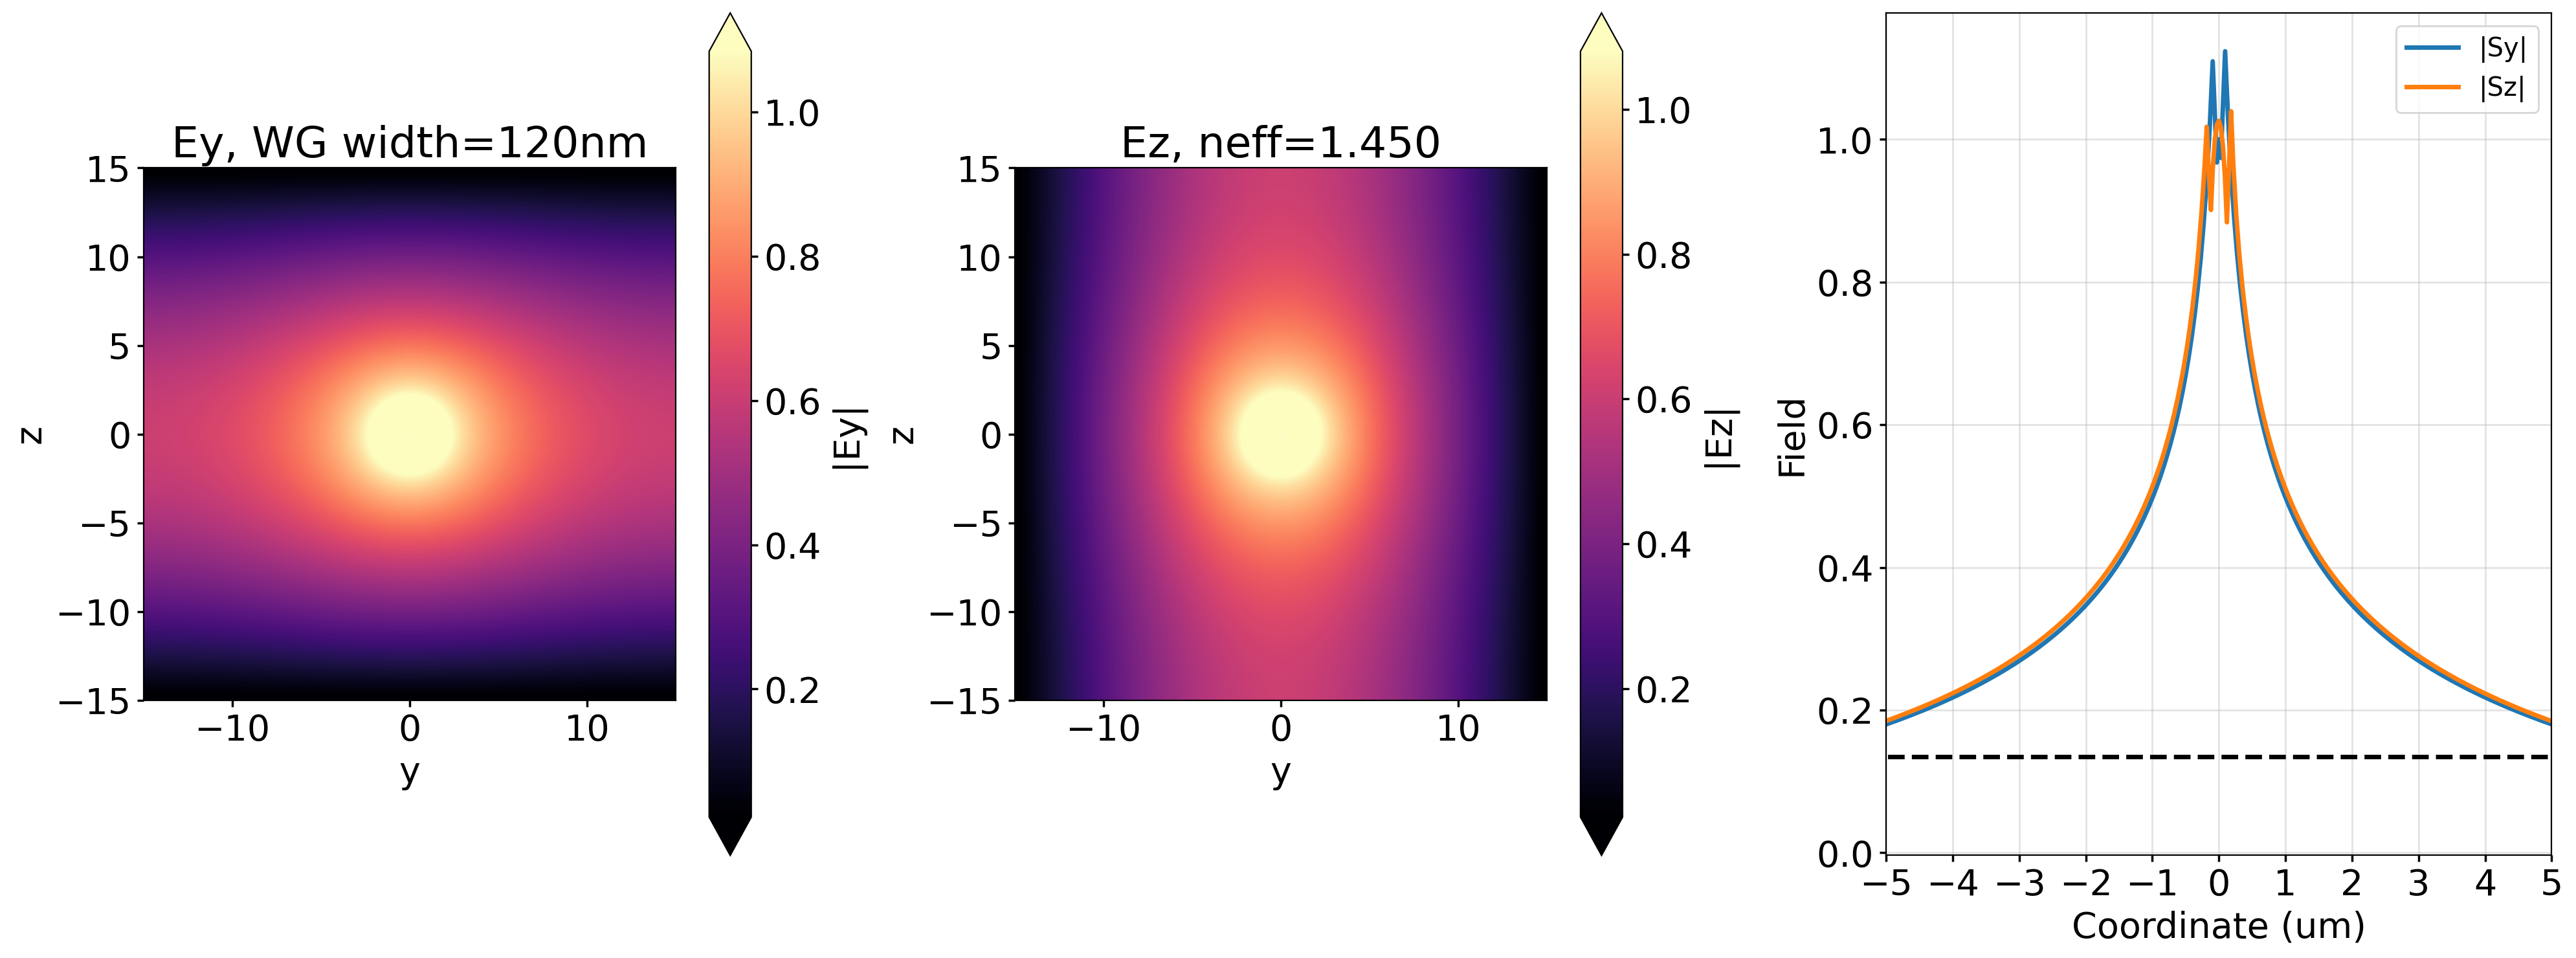

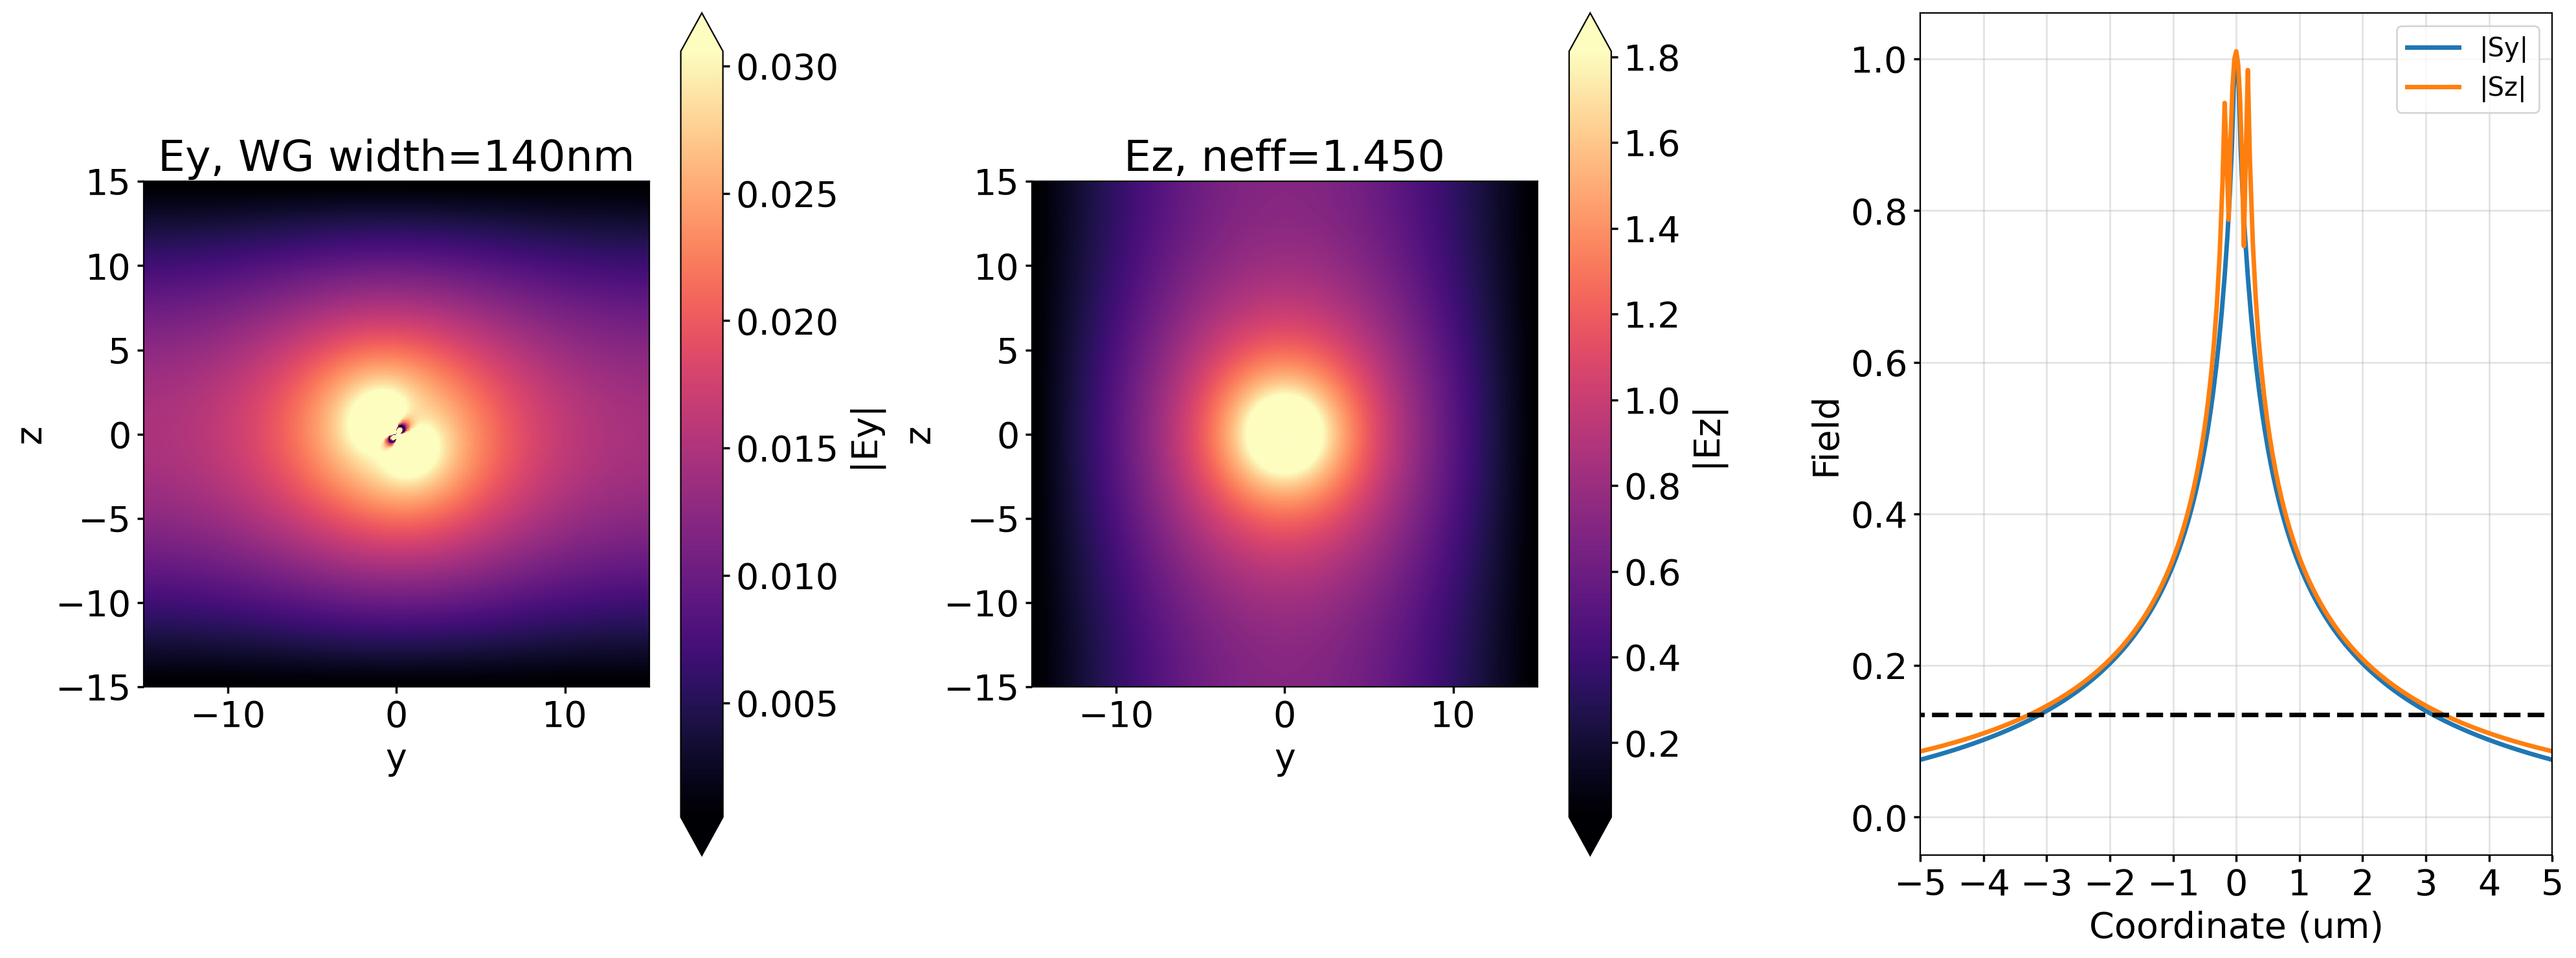

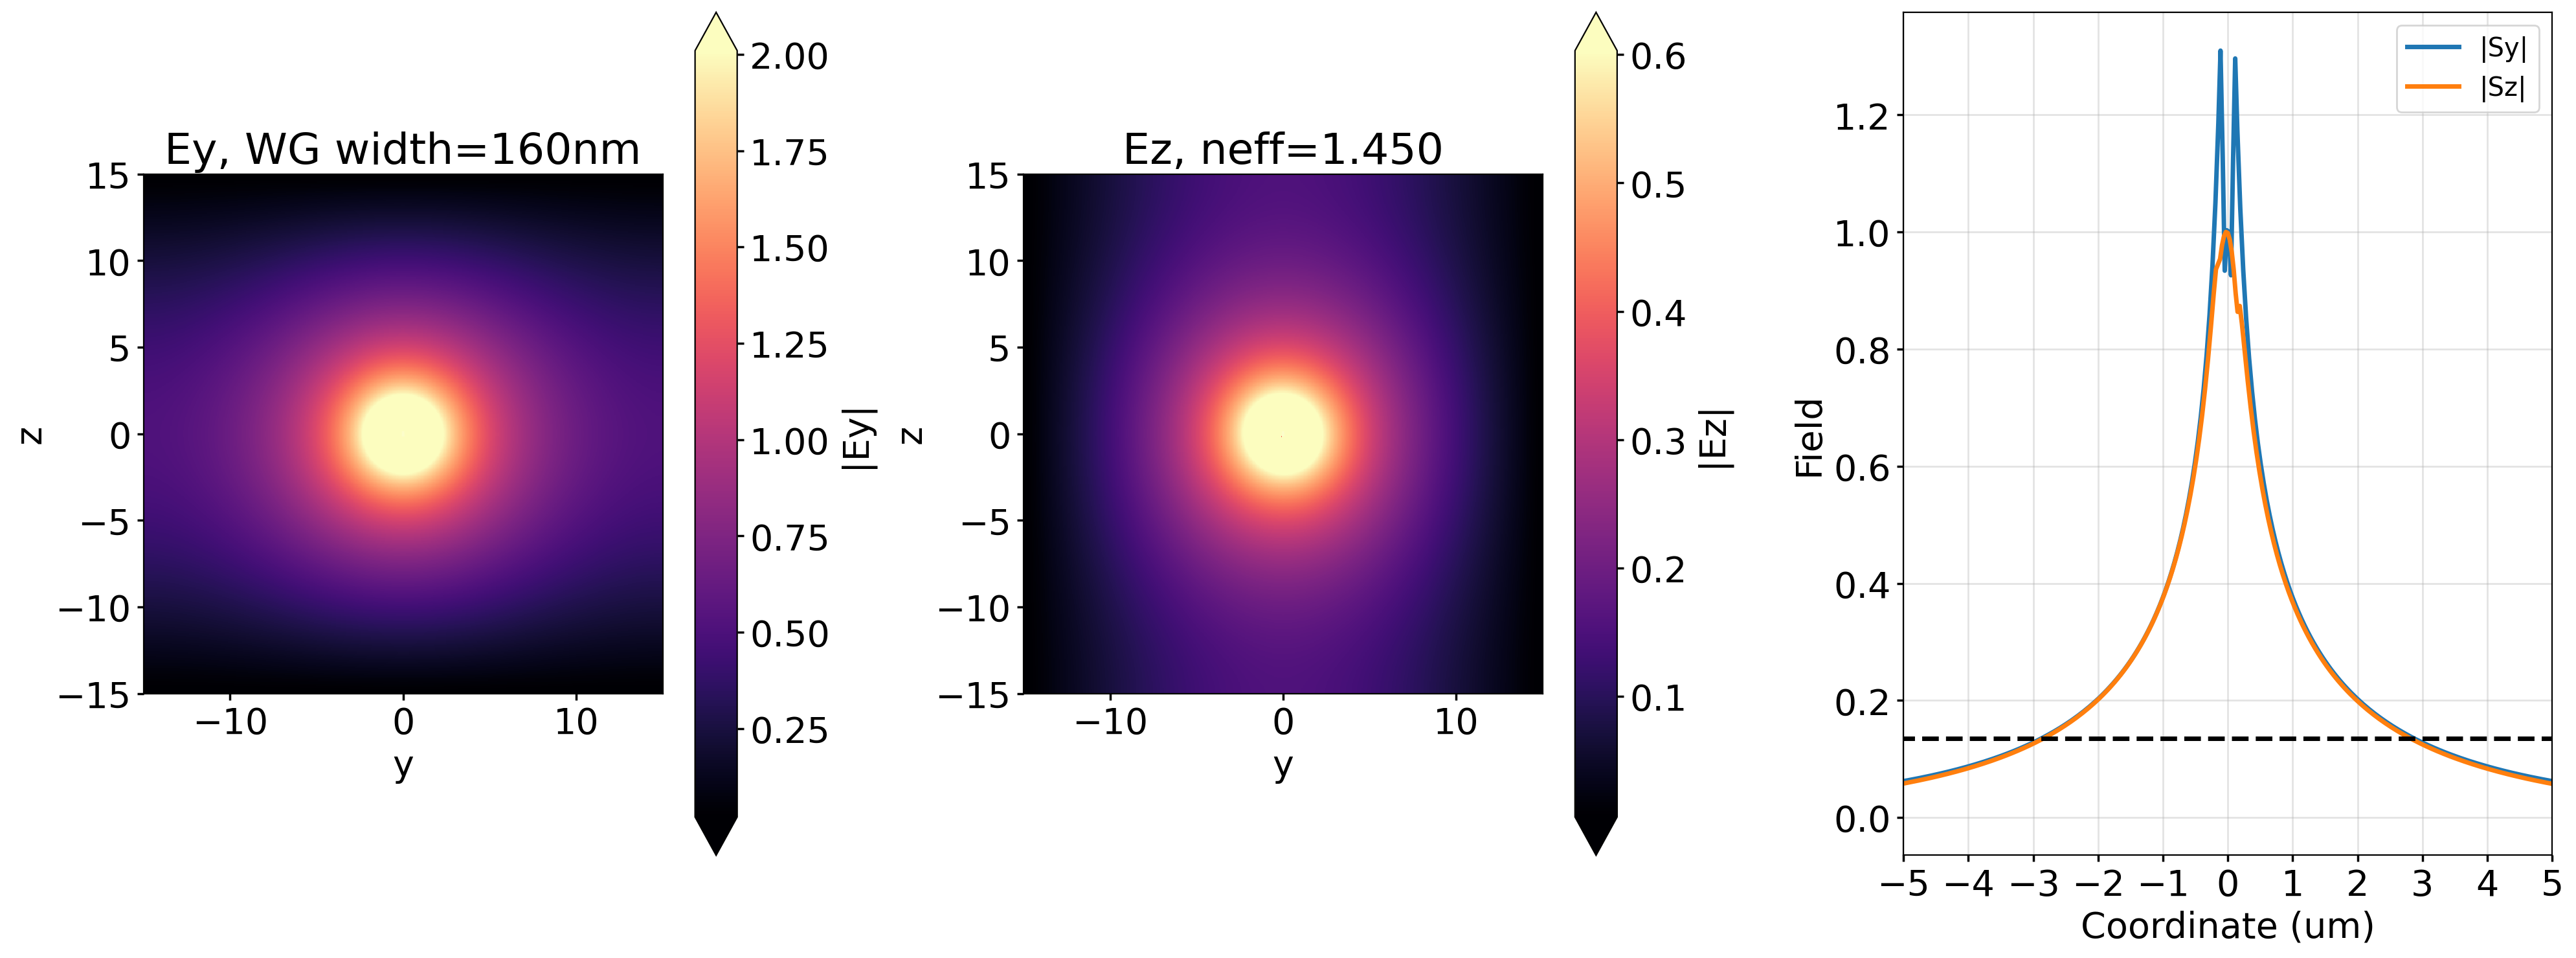

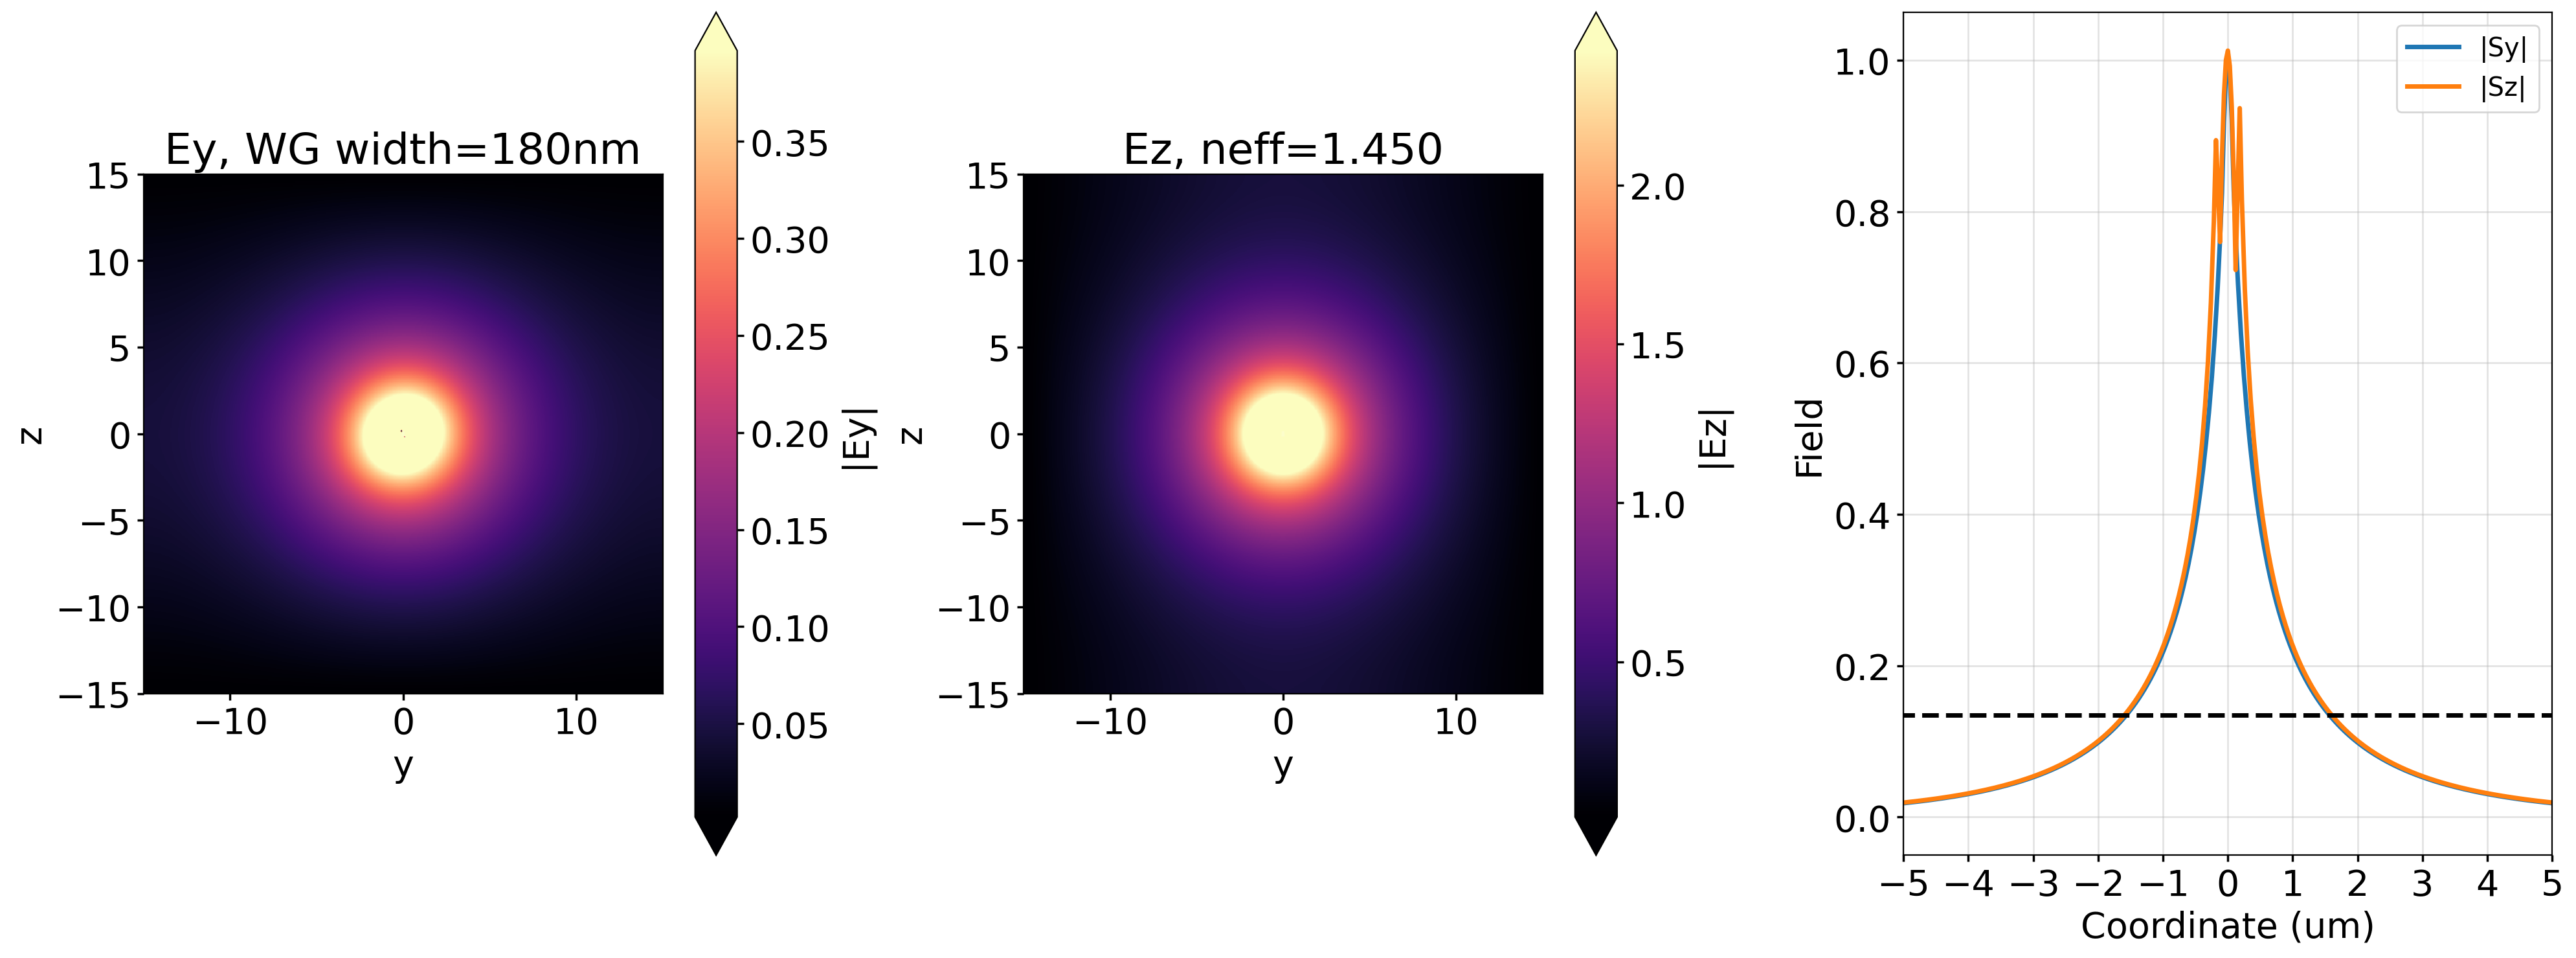

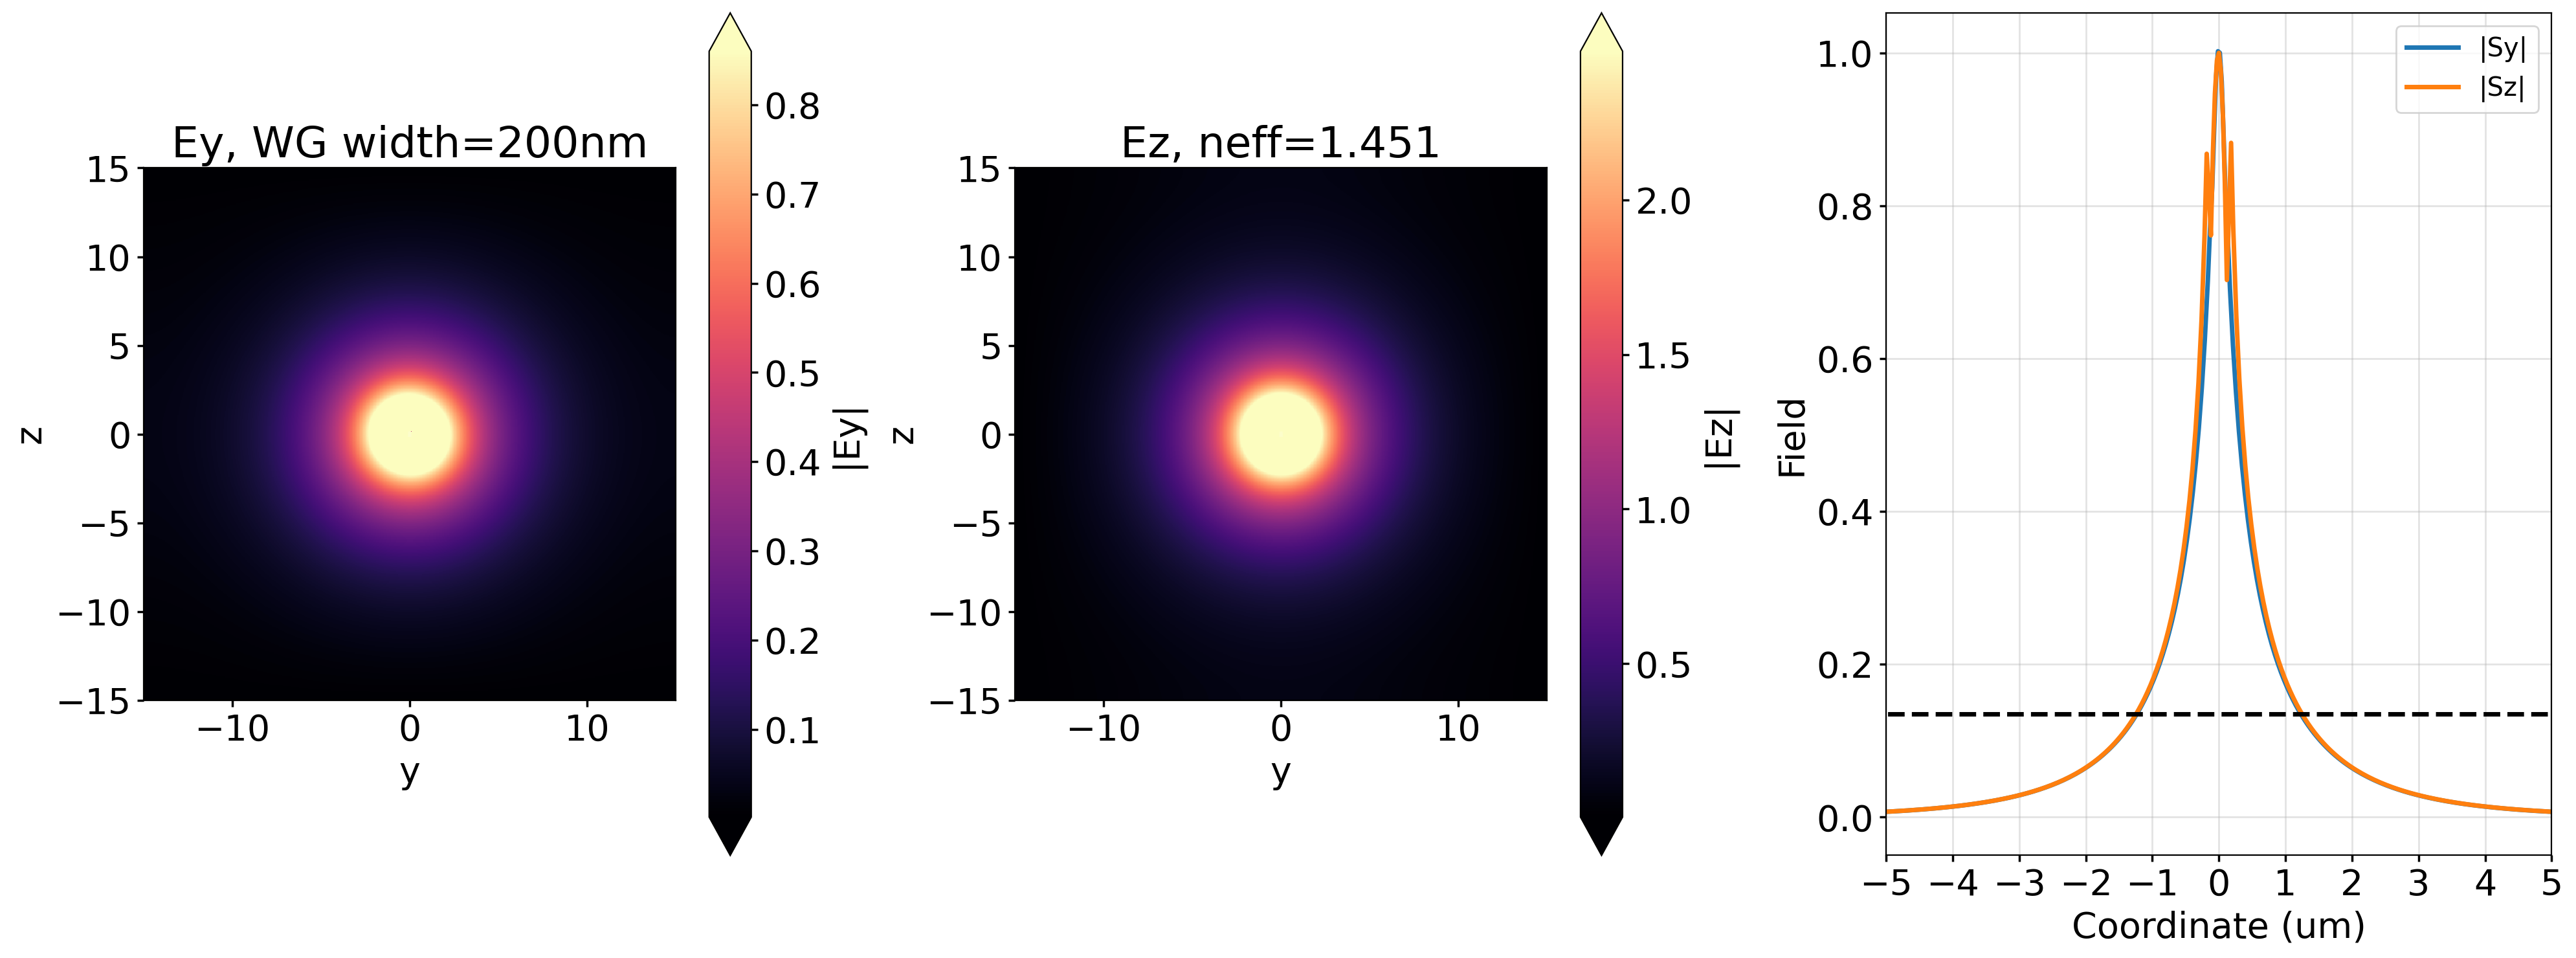

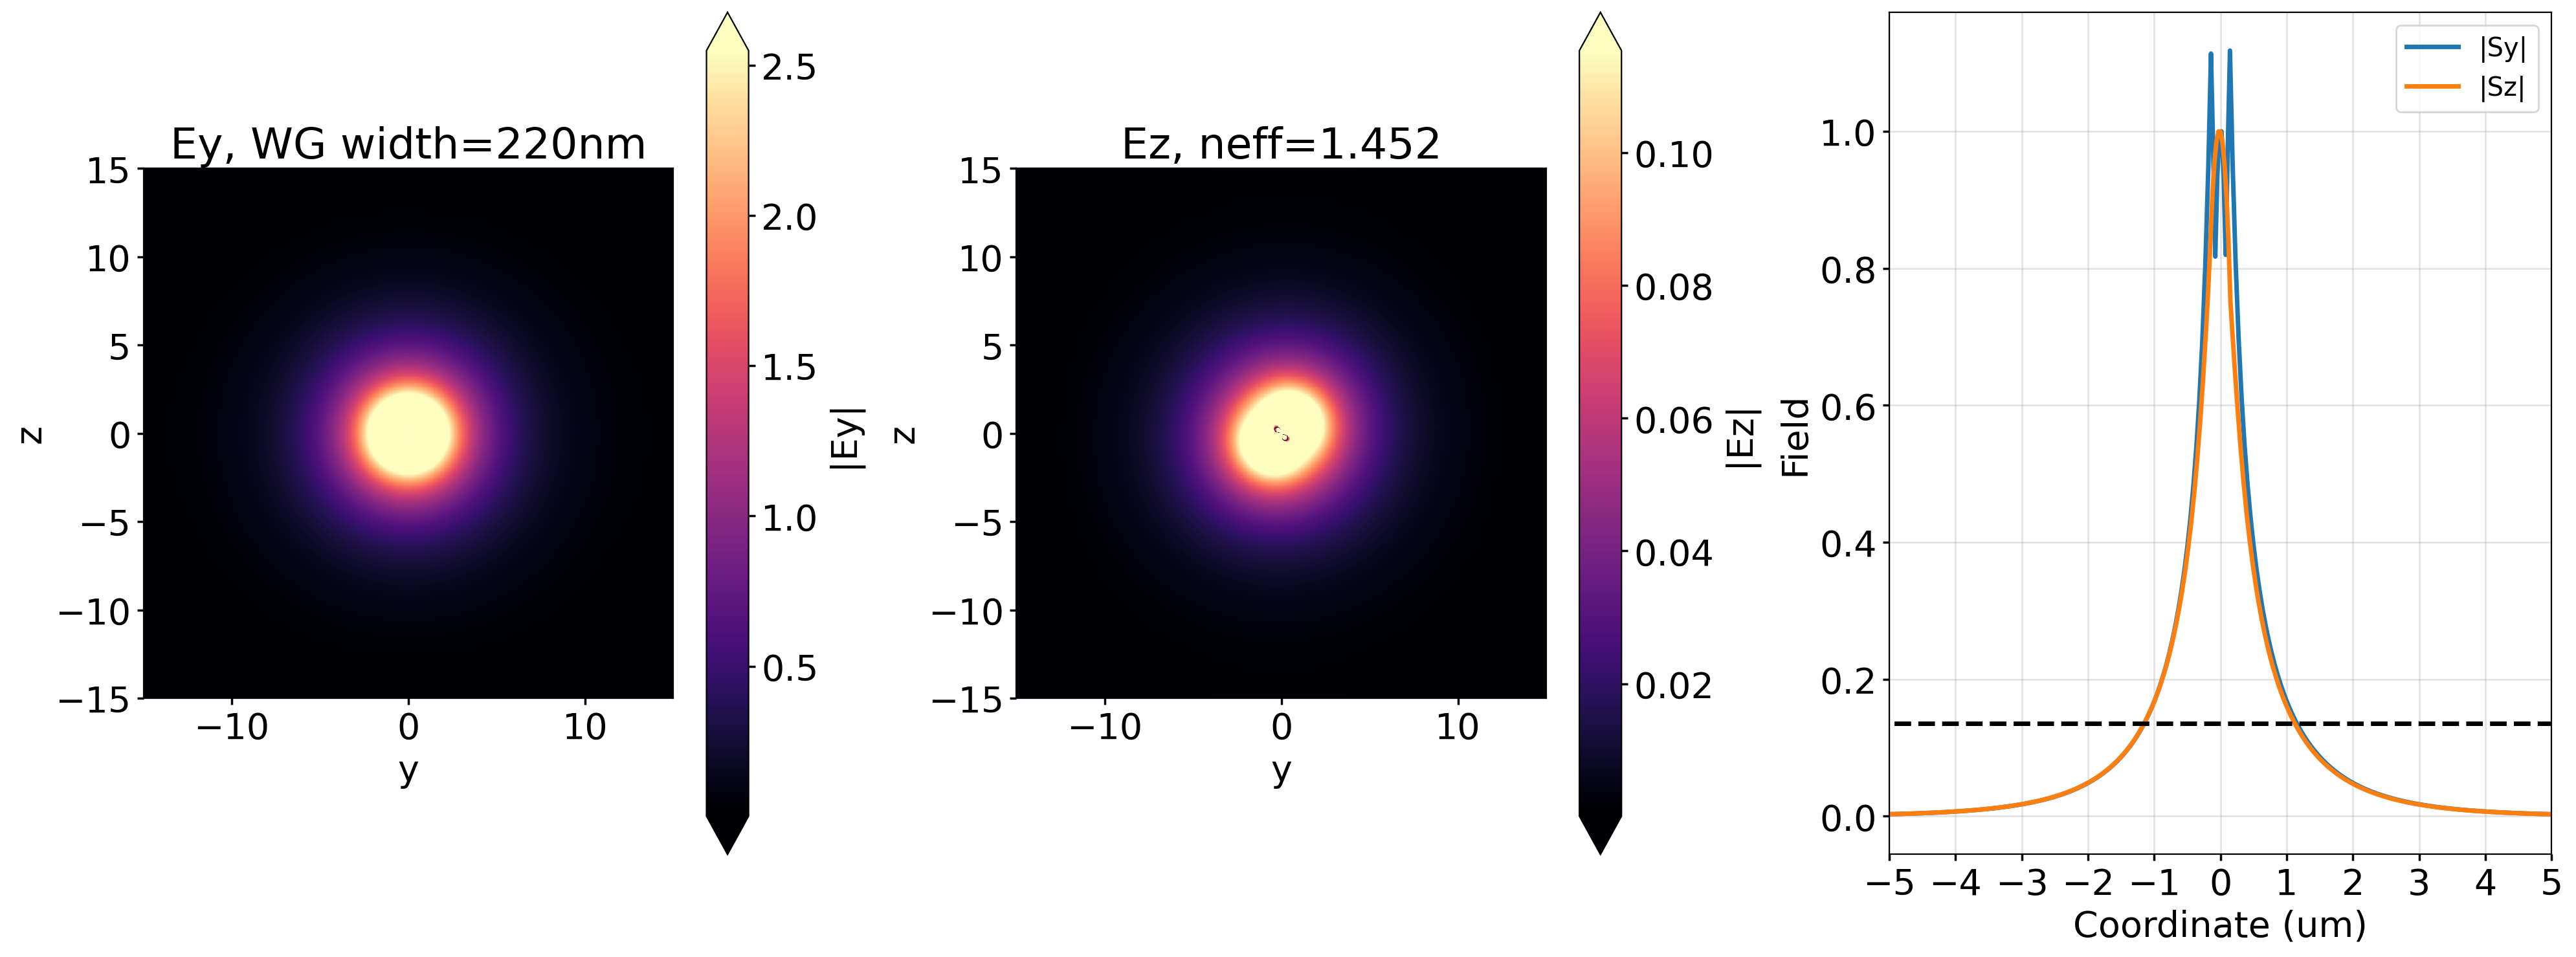

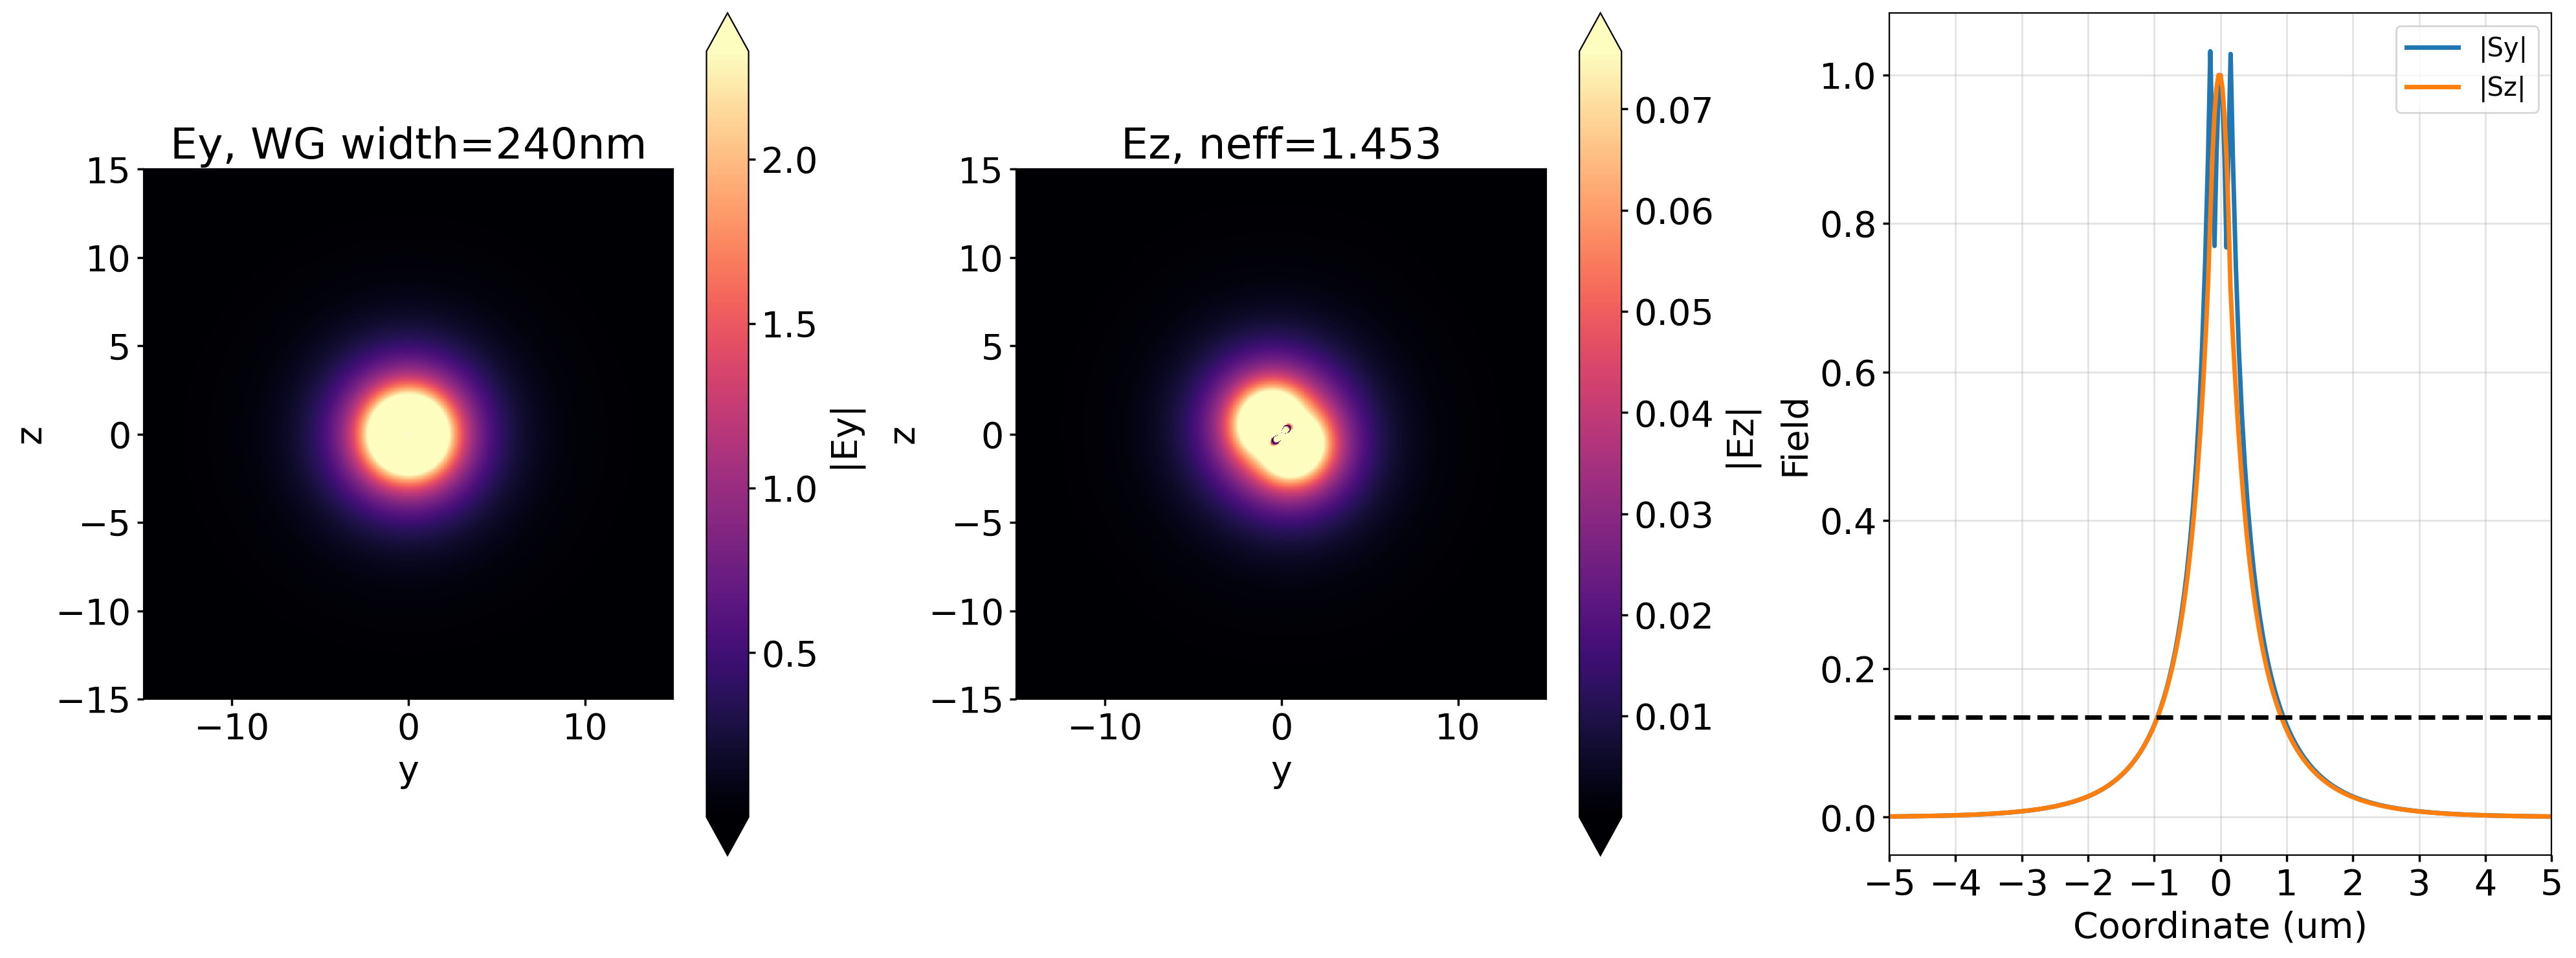

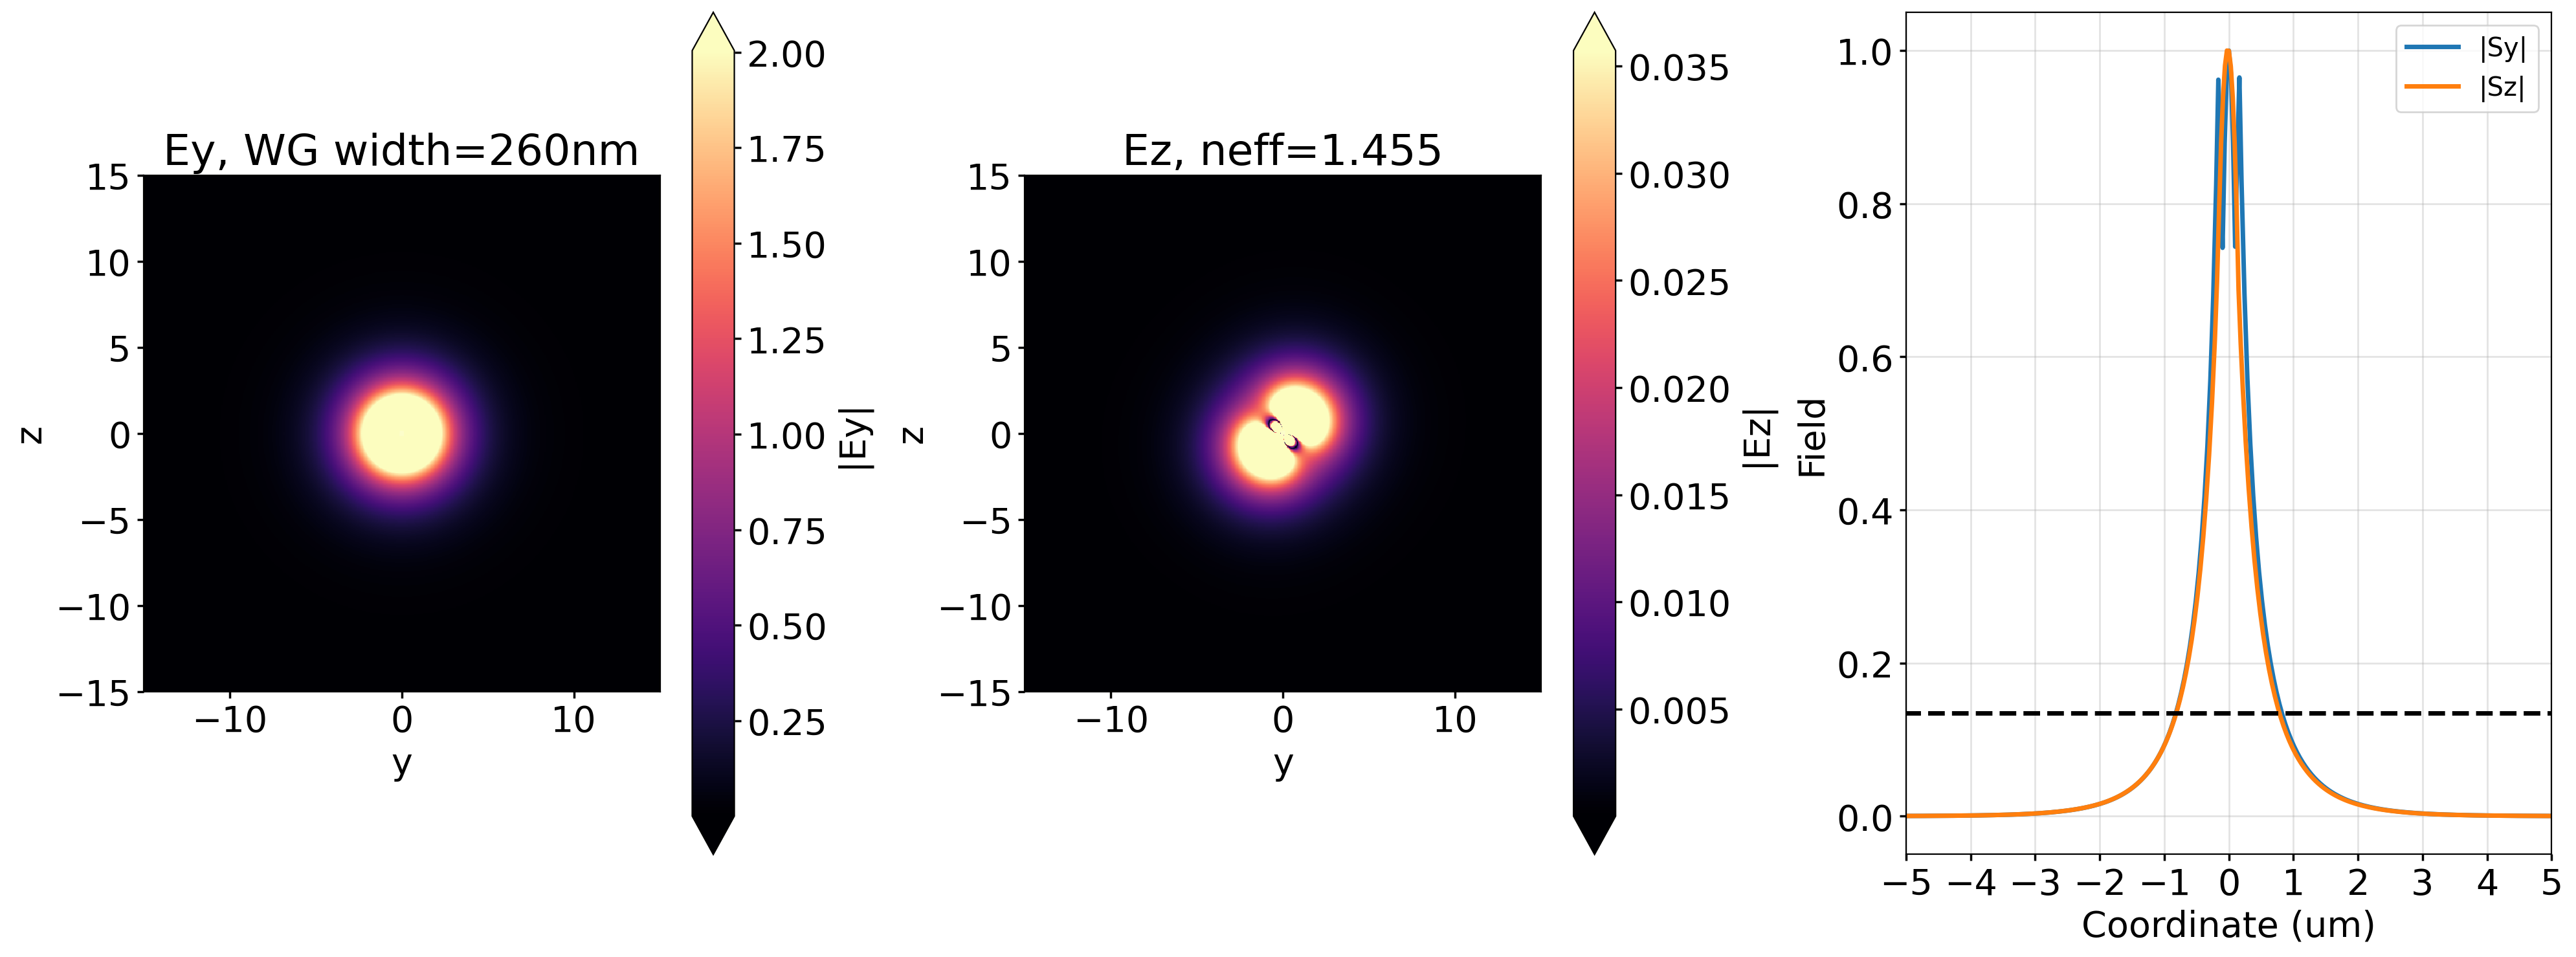

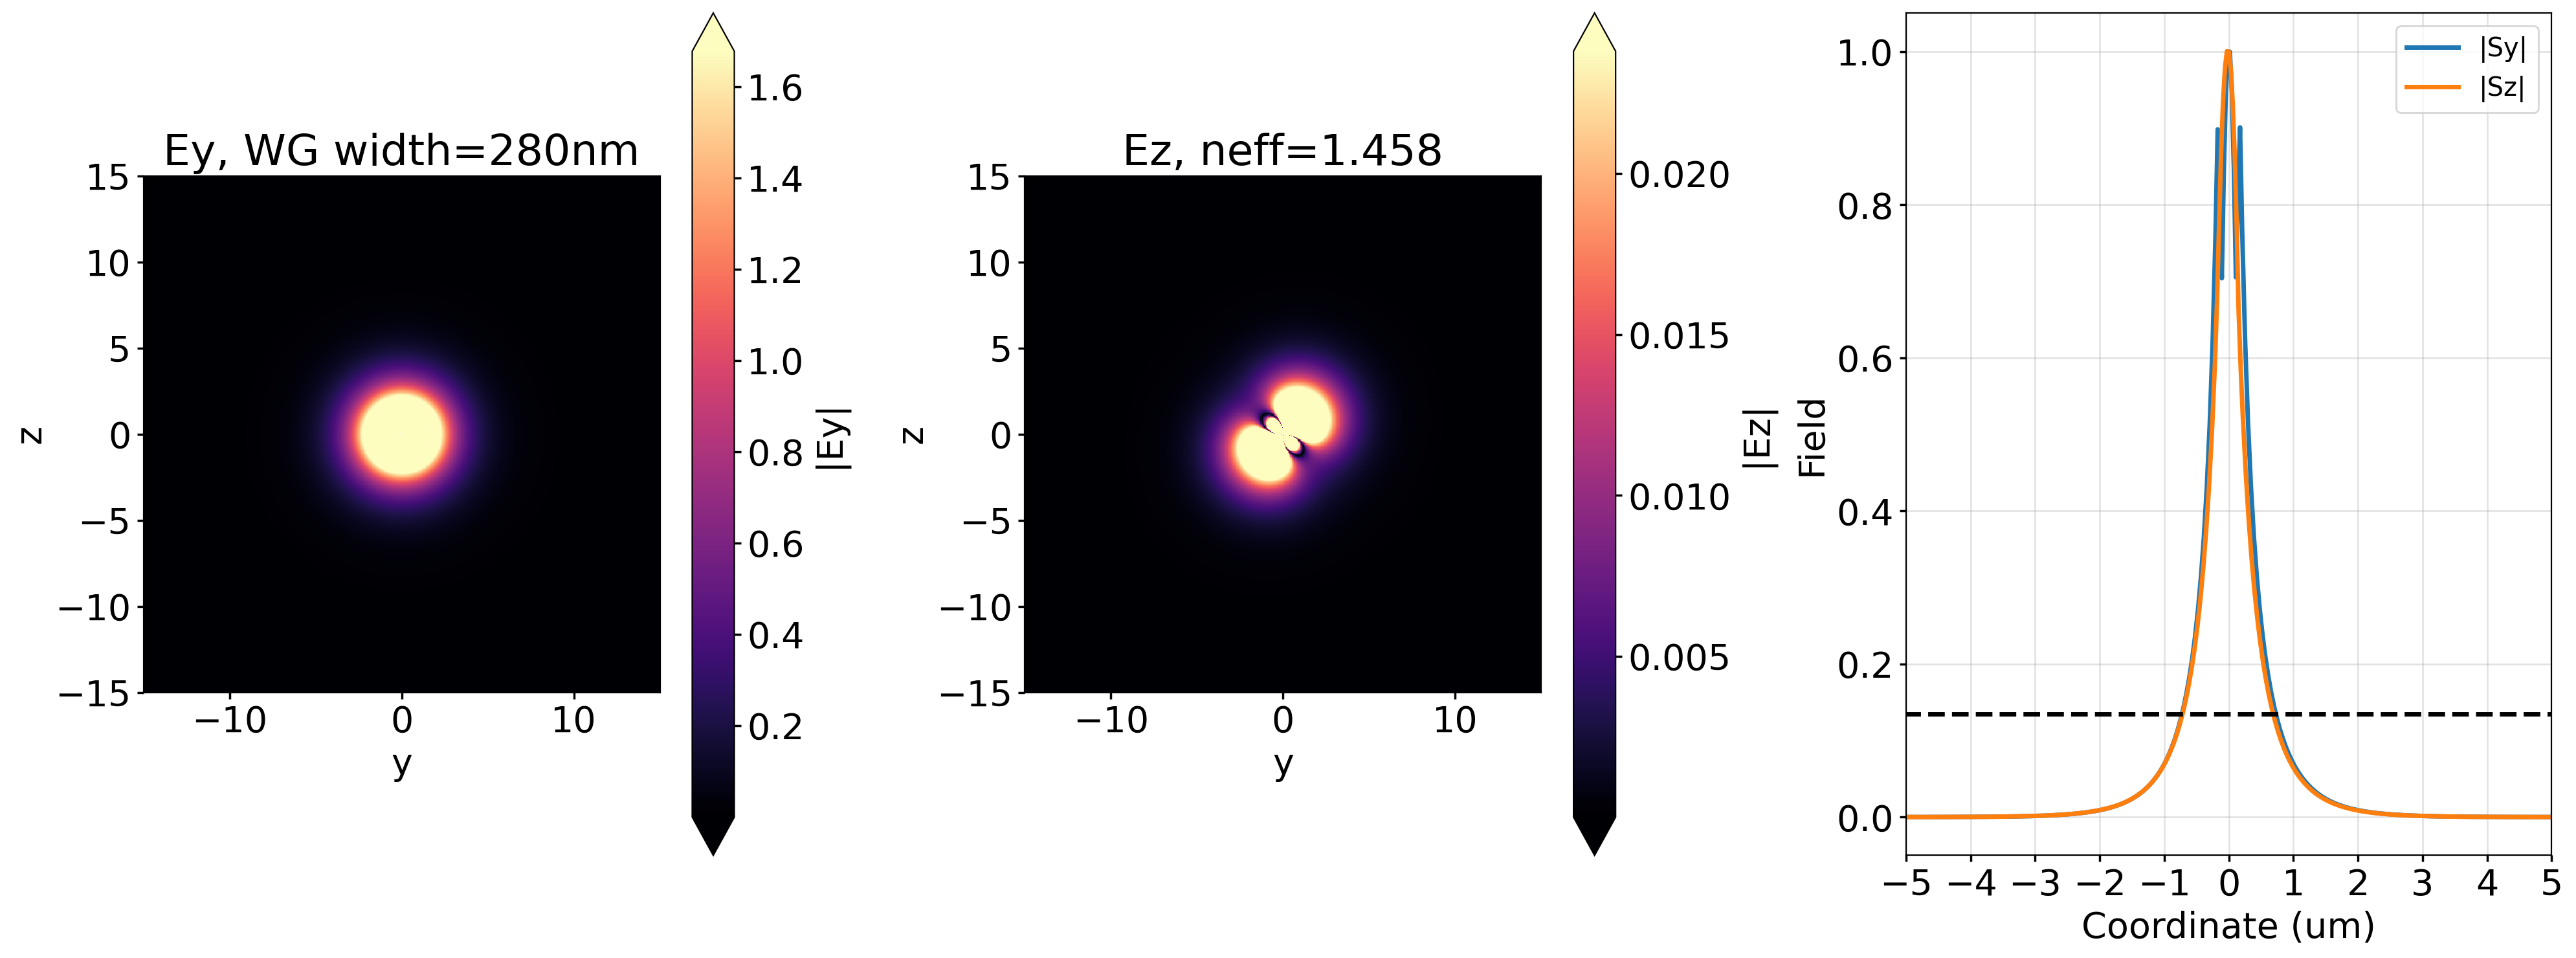

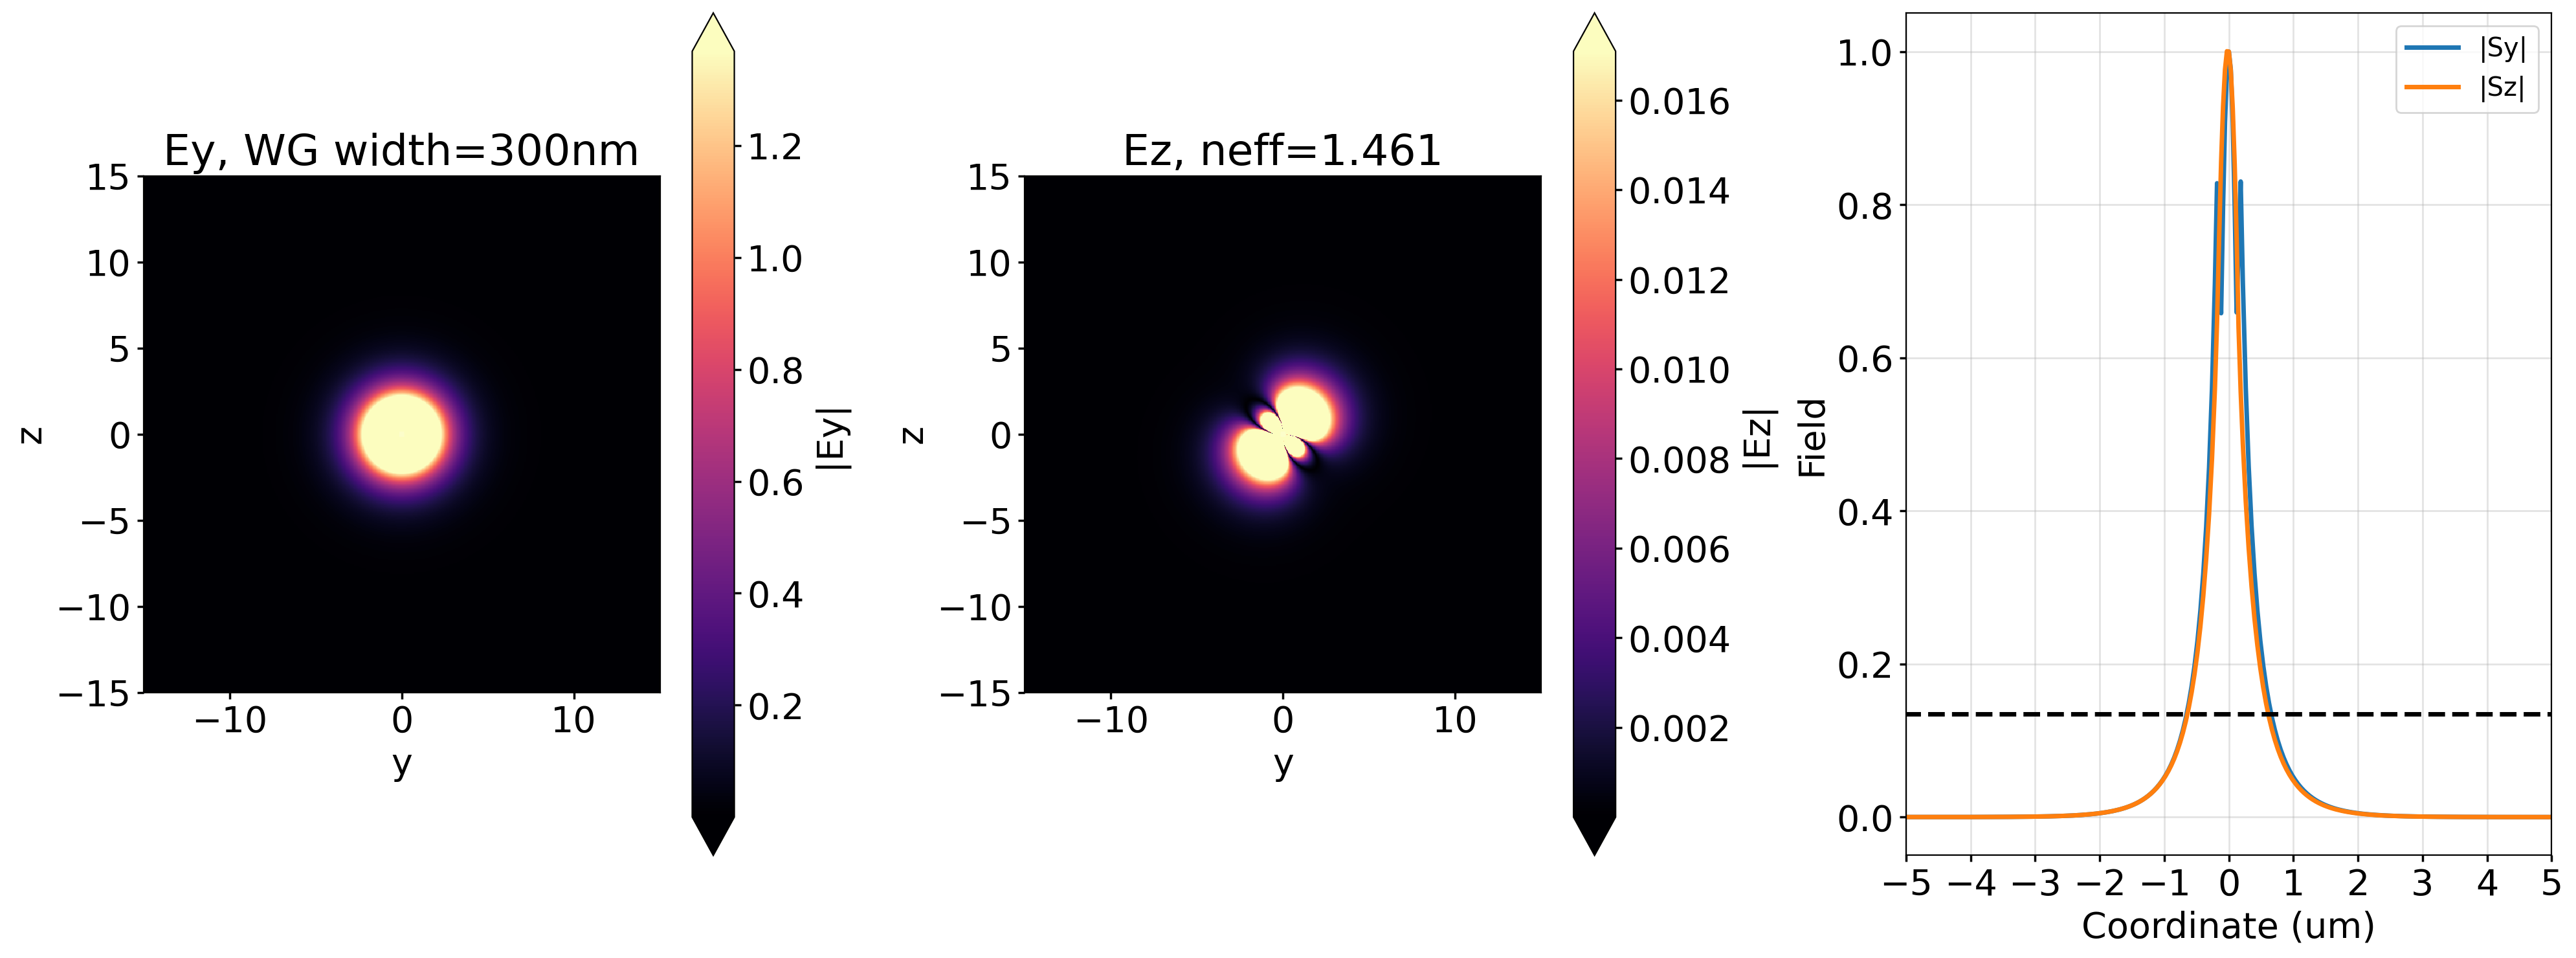

In [5]:
for idd_width in tqdm(range(len(wg_width_range))):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(20, 7.5))
  mode_solver_data[idd_width].plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
  mode_solver_data[idd_width].plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
  ax1.set_title(f"Ey, WG width={wg_width_range[idd_width]*1e3:0.0f}nm")
  ax2.set_title(f"Ez, neff={mode_neff[idd_width]:0.3f}")
  idd_len = len(mode_data[idd_width].poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values)
  ax3.plot(mode_data[idd_width].Ey.y.values, np.abs(mode_data[idd_width].poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values)/np.abs(mode_data[idd_width].poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values)[idd_len//2], label=r"|Sy|")
  ax3.plot(mode_data[idd_width].Ey.z.values, np.abs(mode_data[idd_width].poynting.sel(mode_index=0, f=freq0, y=0, method="nearest").values)/np.abs(mode_data[idd_width].poynting.sel(mode_index=0, f=freq0, y=0, method="nearest").values)[idd_len//2], label=r"|Sz|")
  ax3.plot(mode_data[idd_width].Ey.y.values, np.ones(len(mode_data[idd_width].Ey.y.values))*0.135, "--", color="black")
  ax3.set_xlabel("Coordinate (um)")
  ax3.set_xlim([-5, 5])
  ax3.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
  ax3.set_ylabel("Field")
  ax3.legend()

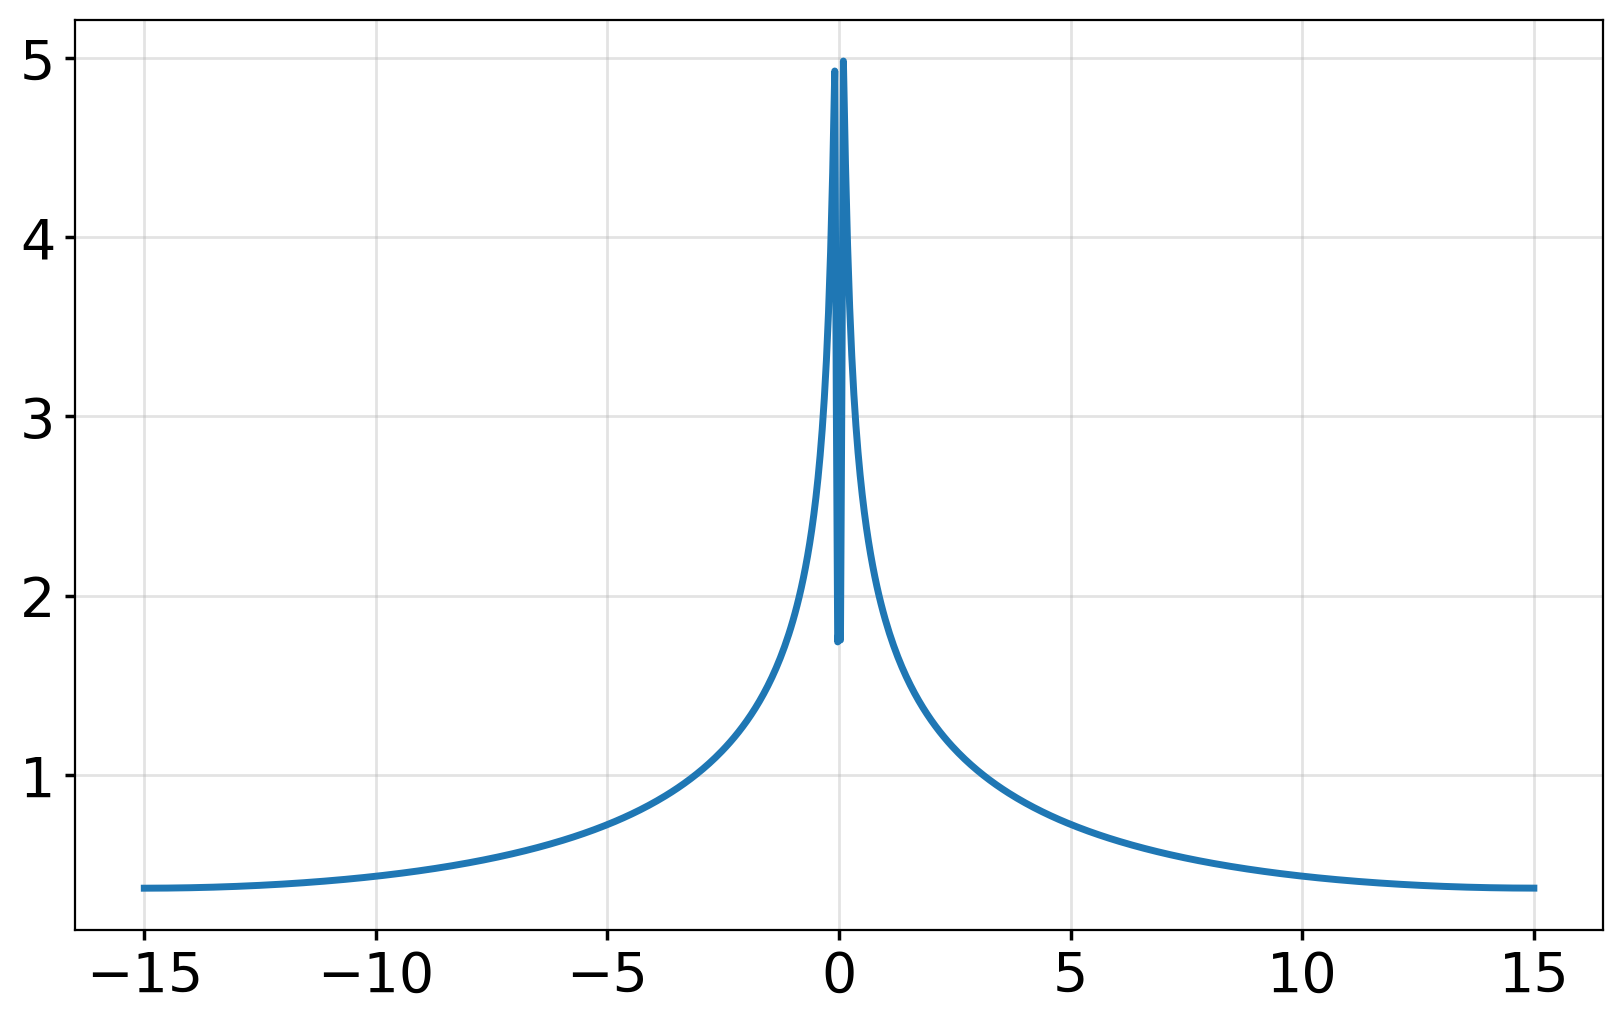

In [6]:
plt.plot(mode_data[1].Ey.y.values, np.abs(mode_data[1].Ey.sel(mode_index=0, f=freq0, x=0, z=0, method="nearest").values)**2, label=r"|Ey|$^2$")

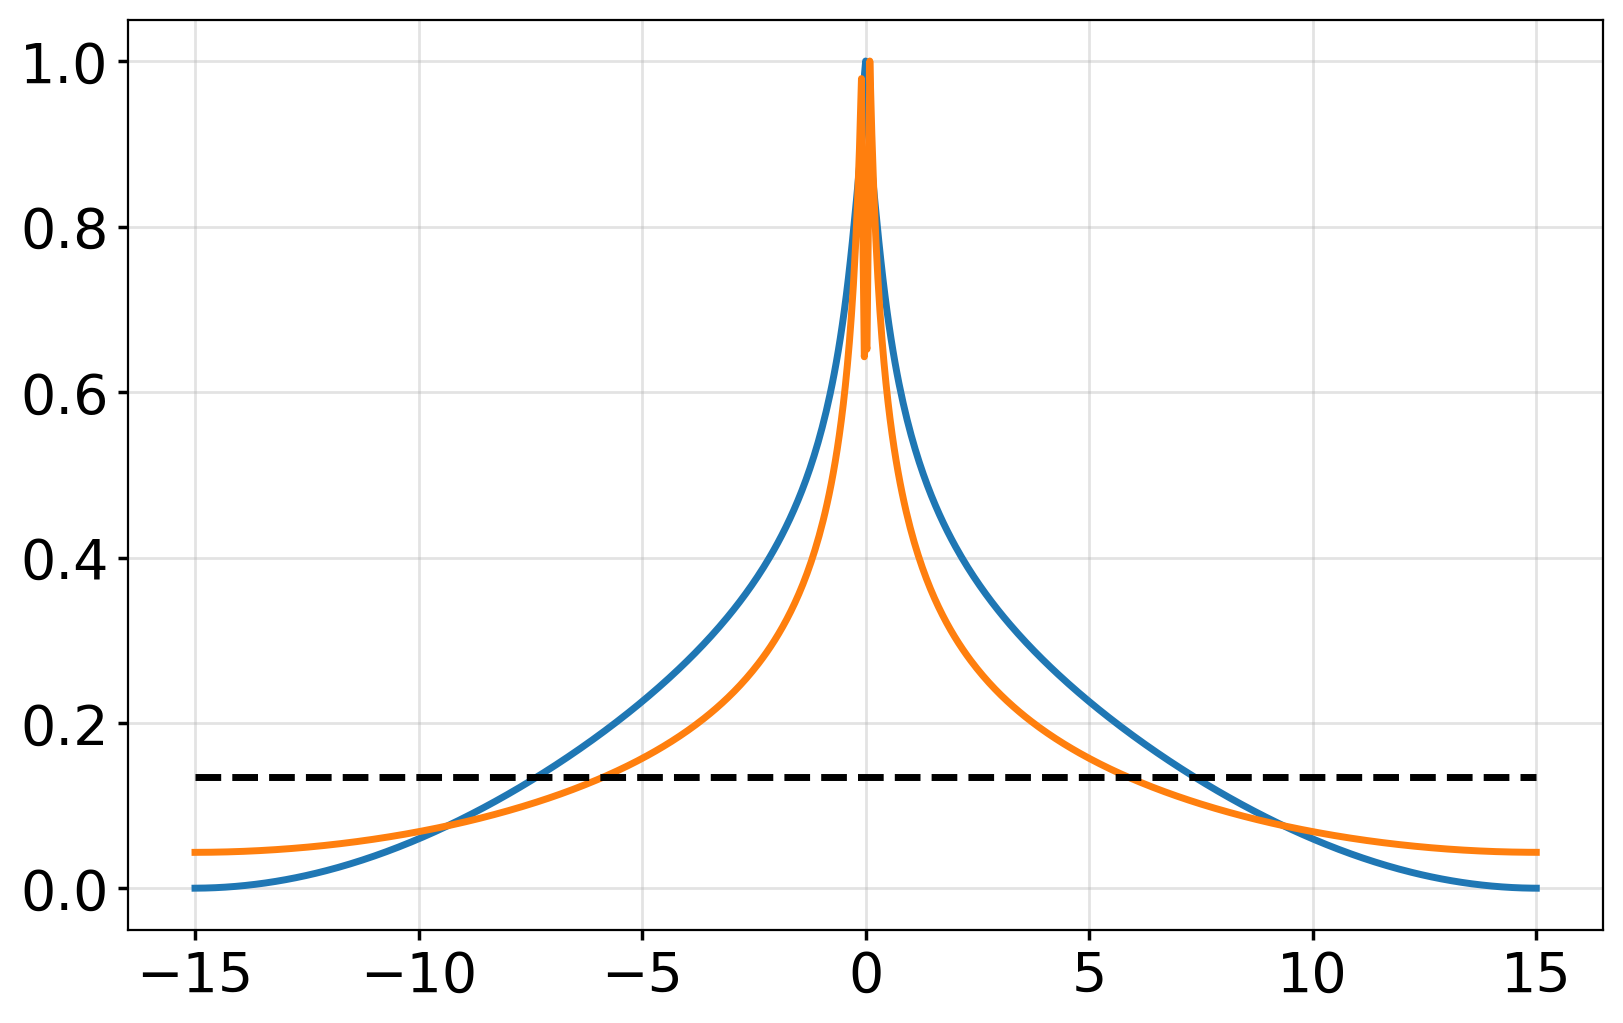

In [7]:
wg_120nm = mode_data[0]
plt.plot(mode_data[0].Ey.y.values, wg_120nm.intensity.sel(mode_index=0, f=freq0, z=0, method="nearest").values/np.max(wg_120nm.intensity.sel(mode_index=0, f=freq0, z=0, method="nearest").values))
wg_150nm = mode_data[1]
plt.plot(mode_data[1].Ey.y.values, wg_150nm.intensity.sel(mode_index=0, f=freq0, z=0, method="nearest").values/np.max(wg_150nm.intensity.sel(mode_index=0, f=freq0, z=0, method="nearest").values))
plt.plot(mode_data[1].Ey.y.values, np.ones(len(mode_data[1].Ey.y.values))*0.135, "--", color="black")

In [8]:
wg_120nm.mode_area

<xarray.FreqModeDataArray (f: 3, mode_index: 1)>
array([[511.61460439],
       [505.96375439],
       [502.89983983]])
Coordinates:
  * f           (f) float64 2.272e+14 2.288e+14 2.304e+14
  * mode_index  (mode_index) int64 0

In [9]:
wg_150nm.mode_area

<xarray.FreqModeDataArray (f: 3, mode_index: 1)>
array([[463.92893658],
       [457.79683287],
       [441.67130425]])
Coordinates:
  * f           (f) float64 2.272e+14 2.288e+14 2.304e+14
  * mode_index  (mode_index) int64 0

In [10]:
wg_150nm.modes_info

<xarray.Dataset>
Dimensions:           (f: 3, mode_index: 1)
Coordinates:
  * f                 (f) float64 2.272e+14 2.288e+14 2.304e+14
  * mode_index        (mode_index) int64 0
Data variables:
    wavelength        (f) float64 1.319 1.31 1.301
    n eff             (f, mode_index) float32 1.45 1.45 1.45
    k eff             (f, mode_index) float32 0.0 0.0 0.0
    loss (dB/cm)      (f, mode_index) float64 0.0 0.0 0.0
    TE (Ey) fraction  (f, mode_index) float64 0.7038 0.5012 0.7474
    wg TE fraction    (f, mode_index) float64 0.9999 0.9999 0.9999
    wg TM fraction    (f, mode_index) float64 0.9997 0.9997 0.9997
    mode area         (f, mode_index) float64 463.9 457.8 441.7
    group index       (f, mode_index) float32 1.451 1.451 1.451

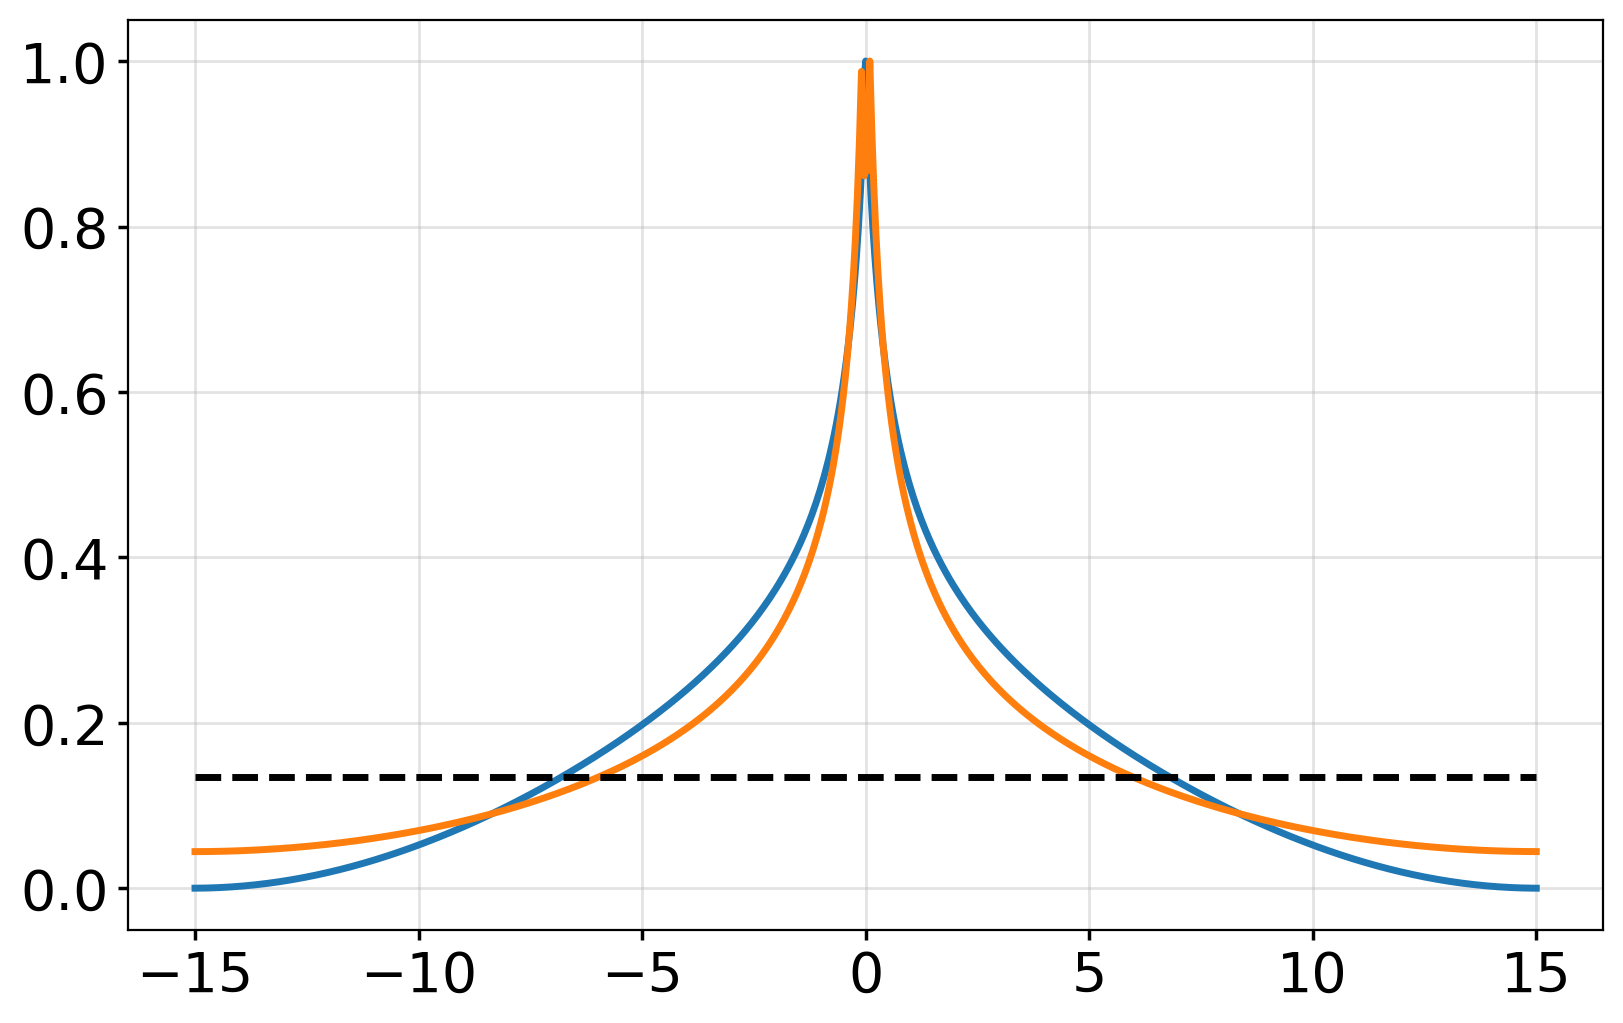

In [11]:
plt.plot(wg_120nm.poynting.y.values, wg_120nm.poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values / np.max(wg_120nm.poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values))
plt.plot(wg_150nm.poynting.y.values, wg_150nm.poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values / np.max(wg_150nm.poynting.sel(mode_index=0, f=freq0, z=0, method="nearest").values))
plt.plot(mode_data[1].Ey.y.values, np.ones(len(mode_data[1].Ey.y.values))*0.135, "--", color="black")